# PBIL Spectral Satelite Image Classification

## Imports

In [1]:
import numpy as np
import pandas as pd

import wandb

import matplotlib.pyplot as plt

from tqdm.notebook import trange

from joblib import Parallel, delayed

/tmp/ipykernel_17545/3677390685.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## PBIL class

In [2]:
class PBIL:
    def __init__(self,
                 chromosome_length,
                 population_size,
                 learning_rate,
                 mutation_rate,
                 mutation_distortion_rate,
                 objective,
                 name=None,
                 wandb_log=True):
        self.chromosome_length = chromosome_length
        self.population_size = population_size
        self.learning_rate = learning_rate
        self.mutation_rate = mutation_rate
        self.mutation_distortion_rate = mutation_distortion_rate
        self.name = name
        self.objective = objective
        self.best_chromosome = (0, np.zeros((self.chromosome_length,)))
        
        self.wandb_log = wandb_log

        self.probabilities = np.ones((self.chromosome_length,))*0.5
        self.resample_population()

        self.objective_values = []
        self.historical_probabilities = []

    def resample_population(self):
        population = np.random.random((self.population_size, self.chromosome_length))
        population = (population < self.probabilities).astype('int')
        self.population = population

    def evaluate_objective(self):
        objective = self.objective(self.population)
        self.objective_values.append(self.objective(self.population))
        self.historical_probabilities.append(self.probabilities.tolist())
        if self.wandb_log:
            logs = {
                'objective_best': objective.max(),
                'objective_worst': objective.min(),
                'objective_avg': objective.mean(),
                'probabilities_vector': self.probabilities.tolist()
            }
            logs.update(
                {f'probability_{key}': value for key, value in enumerate(self.probabilities.tolist())}
            )
            wandb.log(logs)

    def evolve(self, epochs):
        for epoch in trange(epochs):
            self.evaluate_objective()
            best_chromosome = self.population[self.objective_values[-1].argmax()]
            best_chromosome_value = self.objective_values[-1].max()
            if best_chromosome_value > self.best_chromosome[0]:
                self.best_chromosome = (best_chromosome_value, best_chromosome)
            if self.wandb_log:
                wandb.log({
                    "epoch": epoch,
                    "best_chromosome": self.best_chromosome[1],
                    "best_chromosome_value": self.best_chromosome[0]
                })
            self.probabilities = self.probabilities*(1-self.learning_rate) + self.learning_rate*best_chromosome

            if np.random.rand() < self.mutation_rate:
                self.probabilities = self.probabilities*(1-self.mutation_distortion_rate) + self.mutation_distortion_rate*int(np.random.rand()<0.5)

            self.resample_population()
        self.evaluate_objective()

    def plot_evolution(self, backend='plt'):
        if backend == 'plotly':
            fig = make_subplots(rows=1, cols=2)
            for line, values in self.get_scores().items():
                fig.add_trace(
                    go.Scatter(y=values, mode='lines', name=line), row=1, col=1
                )
        
            for i, prob in enumerate(zip(*self.get_historical_probabilities())):
                fig.add_trace(
                    go.Scatter(y=prob, mode='lines', name=i), row=1, col=2
                )
    
            fig.update_layout(width=1200, height=600, title_text="PBIL Experiment")
            fig.show()
        else:

            # Create subplot with two plots
            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            
            # Plot line plot in first plot
            for line, values in self.get_scores().items():
                axs[0].plot(values, label=line)
            axs[0].axhline(9350, linestyle='--')
            axs[0].set_title('Objective')
            axs[0].legend()
            
            # Plot scatter plot in second plot
            for i, prob in enumerate(zip(*self.get_historical_probabilities())):
                axs[1].plot(prob, label=str(i))
            axs[1].set_title('Probabilities')
            
            # Adjust spacing between plots
            plt.subplots_adjust(wspace=0.3)
            
            # Display plot
            plt.suptitle('PBIL Experiment')
            if self.wandb_log:
                wandb.log({'final_plot': wandb.Image(fig)})
        
            plt.show()
            

    def get_scores(self):
        return {
            f'best_score_{self.name}': [scores.max() for scores in self.objective_values],
            f'mean_score_{self.name}': [scores.mean() for scores in self.objective_values],
            f'worst_score_{self.name}': [scores.min() for scores in self.objective_values]
        }

    def get_historical_probabilities(self):
        return self.historical_probabilities


## Data loading

In [12]:
with open('satelite_data/ImageExpertReduced.txt', 'r') as expert_file:
    ground_truth = expert_file.read().split()
ground_truth = np.array([int(float(x)) for x in ground_truth])

In [13]:
ground_truth_series = pd.Series(ground_truth)

In [14]:
ground_truth_series.value_counts()

3    3683
1    2991
2    2676
Name: count, dtype: int64

In [28]:
with open('satelite_data/ImageRawReduced.txt', 'r') as data_file:
    satelite_images = data_file.read().splitlines()
satelite_images = [[float(x) for x in line.split()] for line in satelite_images]
satelite_images = np.array(satelite_images)

In [18]:
with open('satelite_data/ClassificationRules.txt', 'r') as rules_file:
    rules = rules_file.read().split('\n')[:-1]
rules = [[int(float(x)) for x in rule.split()] for rule in rules]
rules = np.array(rules)

In [19]:
rules.shape

(266, 9350)

## Problem definition

In [12]:
def satelite_image_success(population):
    def evaluate_chromosome(chromosome):
        rules_subset = rules[chromosome.astype('bool')]
        rules_results = pd.DataFrame(rules_subset).mode(axis=0, numeric_only=True, dropna=True).iloc[0, :]
        return (rules_results.to_numpy() == ground_truth).sum()

    cost = Parallel(n_jobs=-1, verbose=0)(delayed(evaluate_chromosome)(population[i]) for i in range(population.shape[0]))
    return np.array(cost)

## Experiments

In [37]:
experiment_configs = [
                # {
                #     "chromosome_length": 266,
                #     "population_size": 12,
                #     "learning_rate": 0.1,
                #     "mutation_rate": 0.1,
                #     "mutation_distortion_rate": 0.05,
                #     "name": '',
                #     "epochs": 4000
                # },
                # {
                #     "chromosome_length": 266,
                #     "population_size": 96,
                #     "learning_rate": 0.1,
                #     "mutation_rate": 0.05,
                #     "mutation_distortion_rate": 0.05,
                #     "name": '',
                #     "epochs": 400
                # },
                # {
                #     "chromosome_length": 266,
                #     "population_size": 144,
                #     "learning_rate": 0.1,
                #     "mutation_rate": 0.05,
                #     "mutation_distortion_rate": 0.05,
                #     "name": '',
                #     "epochs": 400
                # },
                # {
                #     "chromosome_length": 266,
                #     "population_size": 36,
                #     "learning_rate": 0.05,
                #     "mutation_rate": 0.05,
                #     "mutation_distortion_rate": 0.05,
                #     "name": '',
                #     "epochs": 500
                # },
                # {
                #     "chromosome_length": 266,
                #     "population_size": 36,
                #     "learning_rate": 0.1,
                #     "mutation_rate": 0.05,
                #     "mutation_distortion_rate": 0.1,
                #     "name": '',
                #     "epochs": 500
                # },
                # {
                #     "chromosome_length": 266,
                #     "population_size": 300,
                #     "learning_rate": 0.1,
                #     "mutation_rate": 0.05,
                #     "mutation_distortion_rate": 0.1,
                #     "name": '',
                #     "epochs": 150
                # },
                # {
                #     "chromosome_length": 266,
                #     "population_size": 600,
                #     "learning_rate": 0.1,
                #     "mutation_rate": 0.05,
                #     "mutation_distortion_rate": 0.1,
                #     "name": '',
                #     "epochs": 100
                # # },
                # {
                #     "chromosome_length": 266,
                #     "population_size": 12,
                #     "learning_rate": 0.1,
                #     "mutation_rate": 0.05,
                #     "mutation_distortion_rate": 0.05,
                #     "name": '',
                #     "epochs": 1000
                # },
                # {
                #     "chromosome_length": 266,
                #     "population_size": 12,
                #     "learning_rate": 0.1,
                #     "mutation_rate": 0.01,
                #     "mutation_distortion_rate": 0.05,
                #     "name": '',
                #     "epochs": 2000
                # },
                # {
                #     "chromosome_length": 266,
                #     "population_size": 12,
                #     "learning_rate": 0.1,
                #     "mutation_rate": 0.05,
                #     "mutation_distortion_rate": 0.05,
                #     "name": '',
                #     "epochs": 2000
                # },
                {
                    "chromosome_length": 266,
                    "population_size": 36,
                    "learning_rate": 0.05,
                    "mutation_rate": 0.05,
                    "mutation_distortion_rate": 0.05,
                    "name": '',
                    "epochs": 2500
                },
]

In [22]:
def run_pbil_experiment(**kwargs):
    epochs = kwargs.pop('epochs')
    pbil = PBIL(**kwargs, objective=satelite_image_success)
    pbil.evolve(epochs)
    pbil.plot_evolution()

  0%|          | 0/2500 [00:00<?, ?it/s]

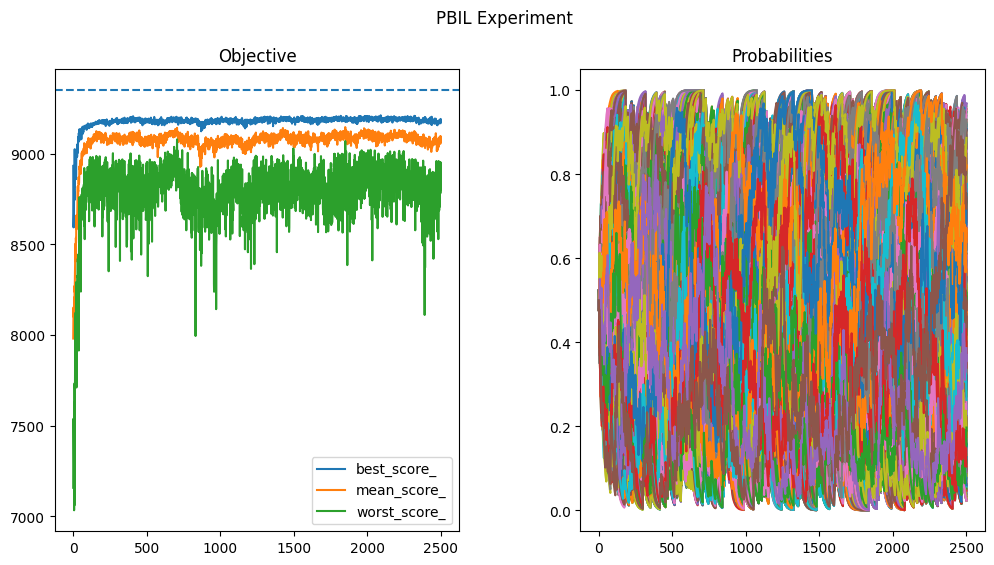

best_chromosome_value,▁▅▆▇▇▇▇█████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
objective_avg,▁▅▇█▇▇██▇▅███▇▆▆▇▇▆▇▇▇▇▇▇▇▆▇▇█▆██▇▇██▇▆▇
objective_best,▁▆▆▇▇▇█▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇█▇▇▆█▇█▇████▇▇▇▇▇
objective_worst,▁▆█▇▄█▇▇▇▆█▇▆▄▆▄▆▅▃▅█▅▇▅▆▅▇▆▇▇▅██▆▇█▇▇▂▇
probability_0,▅▅▆▆▄▃▁▃▂▄▅▅▅▇▆▆▇▇▆▇▆▇█▇███▇▇▅▆▆▇▇█▆▄▅█▇
probability_1,▂▁▃▅▆▇██▇▇▆█▆▇▇▇██▄▇▇▆█▃▅▇▇▇▅███▇▆▅▂▁▁▁▆
probability_10,▄▂▂▁▁▄▂▁▂▂▂▁▂▂▄▃▅▇▆▇▇█▆▅▅▂▃▂▂▁▁▂▁▂▄▃▂▄▃▄
probability_100,▅▆▅▇▆▄▂▆▇▇▇▇▆▇▆▆▇█▆▄▂▄▃▂▂▁▅▃▄▅▆▅▇▅▇██▇▇█
probability_101,▂▁▂▅▇▆▄▃▂▂▄▄▃▁▂▁▂▂▂▄▇▆▅▂▂▅▅▆▇███▇███▇▇▆▇
probability_102,▂▇█▇▆▇█▇▇▇██▄▇█▃▂▁▄▇█▇█▅▆▇▇█▇█▆██▇██▇▆▇▇


In [38]:
for config in experiment_configs:
    wandb.init(project='PBIL_satalite_image_classification', config=config)
    run_pbil_experiment(**config)
    
    wandb.finish()